In [1]:
!python -V


Python 3.11.7


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
df = pd.read_parquet('../../data/yellow_tripdata_2023-01.parquet')

In [7]:
df.shape

(3066766, 19)

In [8]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               3066766 non-null  int64         
 1   tpep_pickup_datetime   3066766 non-null  datetime64[us]
 2   tpep_dropoff_datetime  3066766 non-null  datetime64[us]
 3   passenger_count        2995023 non-null  float64       
 4   trip_distance          3066766 non-null  float64       
 5   RatecodeID             2995023 non-null  float64       
 6   store_and_fwd_flag     2995023 non-null  object        
 7   PULocationID           3066766 non-null  int64         
 8   DOLocationID           3066766 non-null  int64         
 9   payment_type           3066766 non-null  int64         
 10  fare_amount            3066766 non-null  float64       
 11  extra                  3066766 non-null  float64       
 12  mta_tax                30667

In [9]:
rows_before_clean = df.shape[0]

In [10]:
df.nunique()

VendorID                       2
tpep_pickup_datetime     1610975
tpep_dropoff_datetime    1611319
passenger_count               10
trip_distance               4387
RatecodeID                     7
store_and_fwd_flag             2
PULocationID                 257
DOLocationID                 261
payment_type                   5
fare_amount                 6873
extra                         68
mta_tax                       10
tip_amount                  4036
tolls_amount                 776
improvement_surcharge          5
total_amount               15871
congestion_surcharge           3
airport_fee                    3
dtype: int64

In [11]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [12]:
df['duration'].std()

42.594351241920904

In [13]:
df = df[(df.duration >= 1) & (df.duration <= 10)]
rows_after_clean = df.shape[0]
rows_after_clean / rows_before_clean

0.409534995496885

In [14]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)
df_train = pd.get_dummies(df[categorical])

In [15]:
df_train.dtypes

PULocationID_1      bool
PULocationID_10     bool
PULocationID_100    bool
PULocationID_101    bool
PULocationID_102    bool
                    ... 
DOLocationID_94     bool
DOLocationID_95     bool
DOLocationID_96     bool
DOLocationID_97     bool
DOLocationID_98     bool
Length: 482, dtype: object

In [16]:
train_dicts = df_train.to_dict(orient='records')

In [ ]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [ ]:
target = 'duration'
y_train = df[target].values

In [ ]:


lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/tmp/ipykernel_215692/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/home/nathanas/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_215692/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level 

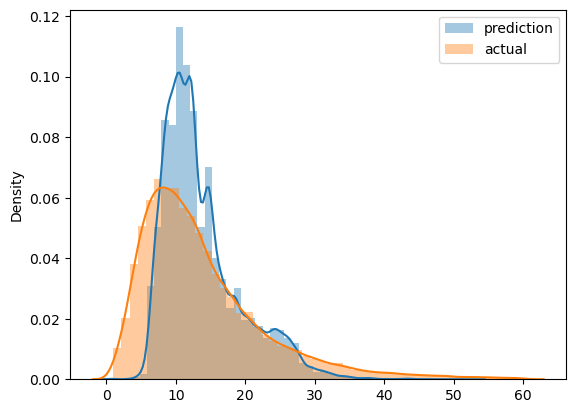

In [18]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [22]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [23]:
df_train = read_dataframe('../../data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('../../data/yellow_tripdata_2023-02.parquet')

In [24]:
len(df_train), len(df_val)

(65946, 62574)

In [26]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [27]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [28]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.034450647708598

In [31]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [32]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

8.231436941224935